<a href="https://colab.research.google.com/github/tariqmhmd5/Multivariate-time-series-forecasting/blob/master/Multivariate_time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option('display.max_rows', 1000)
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True)

In [2]:
confirmed_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('time_series_covid19_recovered_global.csv')
na_columns = (confirmed_df.isna().sum() / confirmed_df.shape[0]) > 0.99
na_columns = na_columns[na_columns]

confirmed_df = confirmed_df.drop(na_columns.index, axis=1)
deaths_df = deaths_df.drop(na_columns.index, axis=1)
recoveries_df = recoveries_df.drop(na_columns.index, axis=1)
confirmed_df = confirmed_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='confirmed')
deaths_df = deaths_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='deaths')
recoveries_df = recoveries_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='recoveries')
confirmed_df['date'] = pd.to_datetime(confirmed_df['date'])
deaths_df['date'] = pd.to_datetime(deaths_df['date'])
recoveries_df['date'] = pd.to_datetime(recoveries_df['date'])
data=confirmed_df.merge(deaths_df)
data=data[data['Country/Region']=='Canada']
data=data[data['Province/State']=='Alberta']
alberta=pd.read_csv('AB.csv')
alberta.drop(['LOCAL_YEAR', 'LOCAL_MONTH', 'LOCAL_DAY'],axis=1,inplace=True)
alberta = alberta.rename(columns={'LOCAL_DATE': 'date'})
alberta['date'] = pd.to_datetime(alberta['date'])


In [3]:
confirmed_df.to_csv('data')

In [4]:
alberta.set_index('PROVINCE_CODE',inplace=True)
alberta = alberta.rename(index={'AB': 'Alberta','BC':'British Columbia','MB':'Manitoba','NB':'New Brunswick','NL':'Newfoundland and Labrador','NS':'Nova Scotia','NT':'Northwest Territories','NU':'Nunavut','ON':'Ontario','PE':'Prince Edward Island','QC':'Quebec','SK':'Saskatchewan','YT':'Yukon'})
alberta = alberta.rename(columns={'PROVINCE_CODE': 'Province/State'})
alberta.reset_index(inplace=True)

In [5]:
alberta.head()

,PROVINCE_CODE,date,MEAN_TEMPERATURE,MIN_TEMPERATURE,MAX_TEMPERATURE,HEATING_DEGREE_DAYS,MIN_REL_HUMIDITY,MAX_REL_HUMIDITY,total_tested,daily_tested
0,Alberta,2020-11-02,nan,nan,nan,nan,nan,nan,0,0
1,Alberta,2020-12-02,-28.10,-38.00,-18.30,46.10,42.00,75.00,0,0
2,Alberta,2020-02-13,-19.80,-25.60,-14.00,37.80,68.00,82.00,0,0
3,Alberta,2020-02-14,-23.70,-29.40,-17.90,41.70,47.00,72.00,0,0
4,Alberta,2020-02-15,-27.50,-34.80,-20.20,45.50,52.00,72.00,0,0


In [6]:
data=data[data['date']>='2020-02-11']

In [7]:
data.head()

,Country/Region,Province/State,Lat,Long,date,confirmed,deaths
5359,Canada,Alberta,53.93,-116.58,2020-02-11,0,0
5625,Canada,Alberta,53.93,-116.58,2020-02-12,0,0
5891,Canada,Alberta,53.93,-116.58,2020-02-13,0,0
6157,Canada,Alberta,53.93,-116.58,2020-02-14,0,0
6423,Canada,Alberta,53.93,-116.58,2020-02-15,0,0


In [8]:
data['date'] = pd.to_datetime(data['date'])

In [9]:
alberta['date'] = pd.to_datetime(alberta['date'])

In [10]:
full_df=data.merge(alberta)

In [11]:
full_df.drop(['Lat', 'Long'],axis=True,inplace=True)

In [12]:
full_df.tail()

,Country/Region,Province/State,date,confirmed,deaths,PROVINCE_CODE,MEAN_TEMPERATURE,MIN_TEMPERATURE,MAX_TEMPERATURE,HEATING_DEGREE_DAYS,MIN_REL_HUMIDITY,MAX_REL_HUMIDITY,total_tested,daily_tested
145,Canada,Alberta,2020-08-08,11430,208,Alberta,14.60,7.60,21.60,3.40,59.00,93.00,613221,0
146,Canada,Alberta,2020-08-13,11969,220,Alberta,14.00,10.80,17.20,4.00,68.00,93.00,647281,5411
147,Canada,Alberta,2020-08-14,12053,221,Alberta,15.30,11.20,19.30,2.70,57.00,91.00,652819,5538
148,Canada,Alberta,2020-08-15,12053,221,Alberta,12.90,5.90,20.00,5.10,46.00,93.00,652819,0
149,Canada,Alberta,2020-08-16,12053,221,Alberta,12.00,5.20,18.80,6.00,67.00,93.00,652819,0


In [13]:
full_df = full_df.rename(columns={'Country/Region': 'Country'})

In [14]:
full_df.isnull().sum()

Country                0
Province/State         0
date                   0
confirmed              0
deaths                 0
PROVINCE_CODE          0
MEAN_TEMPERATURE       0
MIN_TEMPERATURE        0
MAX_TEMPERATURE        0
HEATING_DEGREE_DAYS    0
MIN_REL_HUMIDITY       0
MAX_REL_HUMIDITY       0
total_tested           0
daily_tested           0
dtype: int64

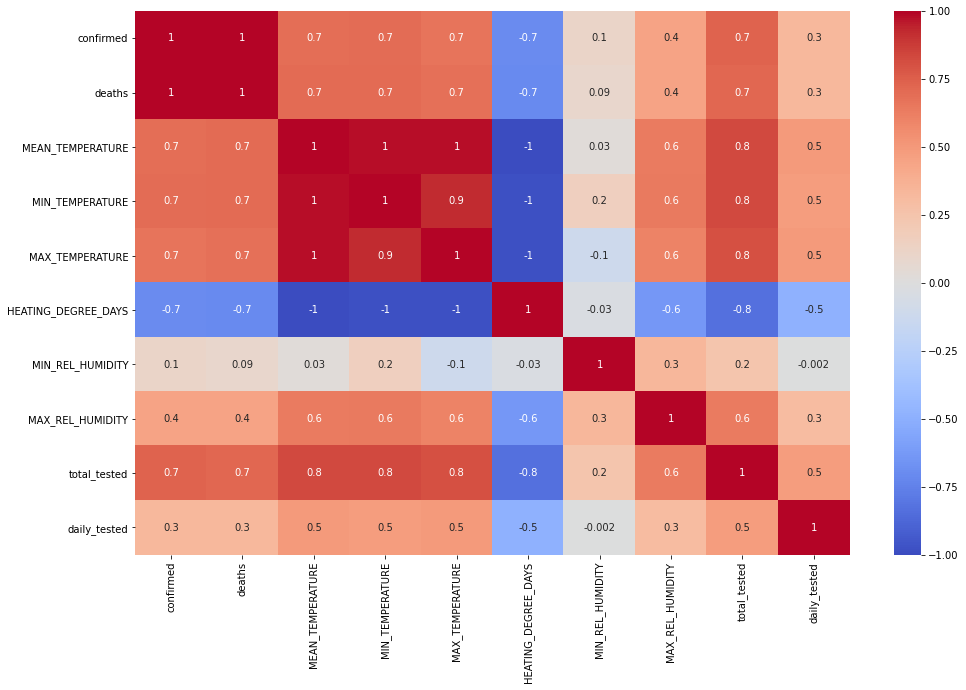

In [15]:
co=full_df.corr()
import seaborn as sns
import matplotlib.pyplot as plt
fig= plt.figure(figsize=(16,10))
sns.heatmap(co,annot=True,fmt='.1g',vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

# Here we Clerly seen the feature Mean Temp, MAx Temp, MIN Temp are postively corelated so we consider only one feature in between them.

## Daily tested and total tested is also postive correlated so we consider only total tested feature.

# 3rd is Min real Humidity have no realation with confirmed cases.

---



In [16]:
full_df.columns

Index(['Country', 'Province/State', 'date', 'confirmed', 'deaths',
       'PROVINCE_CODE', 'MEAN_TEMPERATURE', 'MIN_TEMPERATURE',
       'MAX_TEMPERATURE', 'HEATING_DEGREE_DAYS', 'MIN_REL_HUMIDITY',
       'MAX_REL_HUMIDITY', 'total_tested', 'daily_tested'],
      dtype='object')

In [17]:
full_df.drop(['PROVINCE_CODE', 'MIN_TEMPERATURE',
       'MAX_TEMPERATURE', 'HEATING_DEGREE_DAYS', 'MIN_REL_HUMIDITY','daily_tested'],axis=1,inplace=True)

In [18]:
full_df.head()

,Country,Province/State,date,confirmed,deaths,MEAN_TEMPERATURE,MAX_REL_HUMIDITY,total_tested
0,Canada,Alberta,2020-02-13,0,0,-19.80,82.00,0
1,Canada,Alberta,2020-02-14,0,0,-23.70,72.00,0
2,Canada,Alberta,2020-02-15,0,0,-27.50,72.00,0
3,Canada,Alberta,2020-02-16,0,0,-24.90,73.00,0
4,Canada,Alberta,2020-02-17,0,0,-29.20,72.00,0


In [19]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=5, cols=1,subplot_titles=("confirmed", "deaths ", "MEAN_TEMPERATURE", "MAX_REL_HUMIDITY","total_tested"))

fig.append_trace(go.Scatter(
    x=full_df['date'],
    y=full_df['confirmed'], name='Canada'
), row=1, col=1 )

fig.append_trace(go.Scatter( 
    x=full_df['date'],
    y=full_df['deaths'], name='Canada'
), row=2, col=1)

fig.append_trace(go.Scatter( 
    x=full_df['date'],
    y=full_df['MEAN_TEMPERATURE'], name='Canada'
), row=3, col=1)

fig.append_trace(go.Scatter( 
    x=full_df['date'],
    y=full_df['MAX_REL_HUMIDITY'], name='Canada'
), row=4, col=1)
fig.append_trace(go.Scatter( 
    x=full_df['date'],
    y=full_df['total_tested'], name='Canada'
), row=5, col=1)


fig.update_layout(height=600, width=600, title_text="Stacked Subplots")
#fig.show()

In [20]:
full_df['new_cases']=full_df['confirmed']-full_df['confirmed'].shift(1)

In [21]:
full_df['new_deaths']=full_df['deaths']-full_df['deaths'].shift(1)

In [22]:
full_df.head()

,Country,Province/State,date,confirmed,deaths,MEAN_TEMPERATURE,MAX_REL_HUMIDITY,total_tested,new_cases,new_deaths
0,Canada,Alberta,2020-02-13,0,0,-19.80,82.00,0,nan,nan
1,Canada,Alberta,2020-02-14,0,0,-23.70,72.00,0,0.00,0.00
2,Canada,Alberta,2020-02-15,0,0,-27.50,72.00,0,0.00,0.00
3,Canada,Alberta,2020-02-16,0,0,-24.90,73.00,0,0.00,0.00
4,Canada,Alberta,2020-02-17,0,0,-29.20,72.00,0,0.00,0.00


In [23]:
fig = make_subplots(rows=5, cols=1,subplot_titles=("new_cases", "new_deaths ", "MEAN_TEMPERATURE", "MAX_REL_HUMIDITY","total_tested"))

fig.append_trace(go.Scatter(
    x=full_df['date'],
    y=full_df['new_cases'], name='Canada'
), row=1, col=1 )

fig.append_trace(go.Scatter( 
    x=full_df['date'],
    y=full_df['new_deaths'], name='Canada'
), row=2, col=1)

fig.append_trace(go.Scatter( 
    x=full_df['date'],
    y=full_df['MEAN_TEMPERATURE'], name='Canada'
), row=3, col=1)

fig.append_trace(go.Scatter( 
    x=full_df['date'],
    y=full_df['MAX_REL_HUMIDITY'], name='Canada'
), row=4, col=1)
fig.append_trace(go.Scatter( 
    x=full_df['date'],
    y=full_df['total_tested'], name='Canada'
), row=5, col=1)


fig.update_layout(height=600, width=600, title_text="Stacked Subplots")
#fig.show()

# LSTM Model for forecasting

In [24]:
full_df.drop(['new_cases','new_deaths'],axis=1,inplace=True)

In [25]:
dataset=full_df

In [26]:
dataset.head()

,Country,Province/State,date,confirmed,deaths,MEAN_TEMPERATURE,MAX_REL_HUMIDITY,total_tested
0,Canada,Alberta,2020-02-13,0,0,-19.80,82.00,0
1,Canada,Alberta,2020-02-14,0,0,-23.70,72.00,0
2,Canada,Alberta,2020-02-15,0,0,-27.50,72.00,0
3,Canada,Alberta,2020-02-16,0,0,-24.90,73.00,0
4,Canada,Alberta,2020-02-17,0,0,-29.20,72.00,0


In [27]:
dataset.drop(['Country','Province/State'],axis=1,inplace=True)

In [28]:
dataset.set_index('date',inplace=True)

In [29]:
dataset.head(21)

,confirmed,deaths,MEAN_TEMPERATURE,MAX_REL_HUMIDITY,total_tested
date,,,,,
2020-02-13,0,0,-19.80,82.00,0
2020-02-14,0,0,-23.70,72.00,0
2020-02-15,0,0,-27.50,72.00,0
2020-02-16,0,0,-24.90,73.00,0
2020-02-17,0,0,-29.20,72.00,0
2020-02-18,0,0,-27.30,77.00,0
2020-02-19,0,0,-12.80,82.00,0
2020-02-20,0,0,-1.10,82.00,0
2020-02-21,0,0,-2.20,81.00,0


In [30]:
dataset.drop('deaths', axis=1, inplace=True)

Cases Started from 06/3/2020 to 16/08/2020

In [31]:
df=dataset[20:]

In [32]:
df.reset_index(drop=True, inplace=True)
data=df.drop(['total_tested'], axis=1)

In [33]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
data = sc.fit_transform(data)

In [34]:
from numpy import array
def split_sequences(sequences, n_steps):
  X, y = list(), list()
  for i in range(len(sequences)):
    end_ix = i + n_steps
    if end_ix > len(sequences)-1:
      break
    seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)

In [35]:
n_steps = 20
# convert into input/output
X, y = split_sequences(data, n_steps)

In [36]:
X.shape

(110, 20, 3)

In [37]:
y.shape

(110, 3)

In [38]:
n_features = X.shape[2]

In [39]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps,n_features)))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse',metrics=['mae'])

In [40]:
# fit model
model.fit(X, y, epochs=40, batch_size = 4)

Epoch 1/40
28/28 [==============================] - 0s 12ms/step - loss: 0.1996 - mae: 0.3513
Epoch 2/40
28/28 [==============================] - 0s 9ms/step - loss: 0.0410 - mae: 0.1351
Epoch 3/40
28/28 [==============================] - 0s 10ms/step - loss: 0.0352 - mae: 0.1296
Epoch 4/40
28/28 [==============================] - 0s 10ms/step - loss: 0.0336 - mae: 0.1238
Epoch 5/40
28/28 [==============================] - 0s 10ms/step - loss: 0.0331 - mae: 0.1233
Epoch 6/40
28/28 [==============================] - 0s 10ms/step - loss: 0.0321 - mae: 0.1194
Epoch 7/40
28/28 [==============================] - 0s 9ms/step - loss: 0.0304 - mae: 0.1177
Epoch 8/40
28/28 [==============================] - 0s 10ms/step - loss: 0.0311 - mae: 0.1189
Epoch 9/40
28/28 [==============================] - 0s 9ms/step - loss: 0.0318 - mae: 0.1188
Epoch 10/40
28/28 [==============================] - 0s 10ms/step - loss: 0.0314 - mae: 0.1219
Epoch 11/40
28/28 [==============================] - 0s 10ms/s

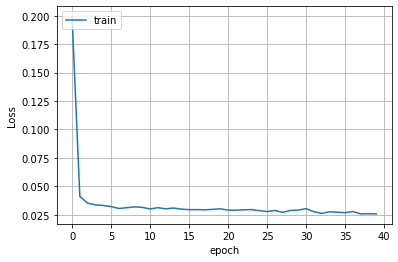

In [41]:
plt.plot(model.history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [42]:
pred=[]
for i in X[-1]:
    pred.append(i)

In [43]:
X[-1].shape

(20, 3)

In [44]:
pred.append(model.predict(X[-1].reshape(1,20,3)))

In [45]:
len(pred)

21

In [46]:
forcast=[]
for i in range(10):
    pred.reverse()
    pred.pop()
    pred.reverse()
    forcast.append(model.predict(np.vstack( pred ).reshape(1,20,3)))
    pred.append(model.predict(np.vstack( pred ).reshape(1,20,3))) 

In [47]:
predictions=sc.inverse_transform(np.vstack(forcast))

# 10 Days Future Forecasting

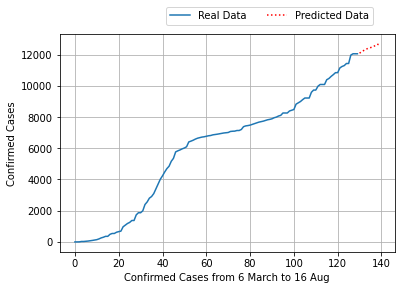

In [48]:
plt.figure()
plt.plot(sc.inverse_transform(data)[:,0],label="Real Data")
plt.plot(pd.DataFrame(predictions[:,0],index=range(data.shape[0],data.shape[0]+10)),label="Predicted Data",c="r",linestyle='dotted')
plt.ylabel("Confirmed Cases")
plt.xlabel("Confirmed Cases from 6 March to 16 Aug")
plt.legend(bbox_to_anchor =(0.95, 1.15), ncol = 2)
plt.grid()
plt.show()

In [49]:
predictin_lstm=pd.DataFrame(predictions[:,0],index=range(data.shape[0],data.shape[0]+10))

In [50]:
model = Sequential()
model.add(GRU(100, activation='relu', input_shape=(n_steps,n_features)))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse',metrics=['mae'])

In [51]:
# fit model
model.fit(X, y, epochs=40, batch_size = 4)

Epoch 1/40
28/28 [==============================] - 0s 11ms/step - loss: 0.1893 - mae: 0.3521
Epoch 2/40
28/28 [==============================] - 0s 10ms/step - loss: 0.0403 - mae: 0.1533
Epoch 3/40
28/28 [==============================] - 0s 9ms/step - loss: 0.0351 - mae: 0.1299
Epoch 4/40
28/28 [==============================] - 0s 9ms/step - loss: 0.0324 - mae: 0.1303
Epoch 5/40
28/28 [==============================] - 0s 9ms/step - loss: 0.0302 - mae: 0.1186
Epoch 6/40
28/28 [==============================] - 0s 9ms/step - loss: 0.0311 - mae: 0.1207
Epoch 7/40
28/28 [==============================] - 0s 9ms/step - loss: 0.0282 - mae: 0.1124
Epoch 8/40
28/28 [==============================] - 0s 11ms/step - loss: 0.0283 - mae: 0.1094
Epoch 9/40
28/28 [==============================] - 0s 11ms/step - loss: 0.0272 - mae: 0.1037
Epoch 10/40
28/28 [==============================] - 0s 11ms/step - loss: 0.0277 - mae: 0.1036
Epoch 11/40
28/28 [==============================] - 0s 10ms/ste

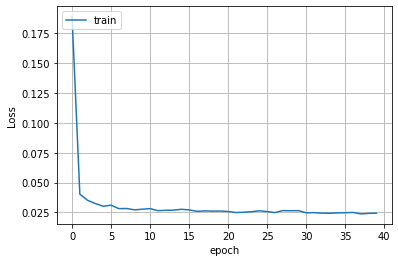

In [52]:
plt.plot(model.history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [53]:
pred=[]
for i in X[-1]:
    pred.append(i)

In [54]:
X[-1].shape

(20, 3)

In [55]:
pred.append(model.predict(X[-1].reshape(1,20,3)))

In [56]:
len(pred)

21

In [57]:
forcast=[]
for i in range(10):
    pred.reverse()
    pred.pop()
    pred.reverse()
    forcast.append(model.predict(np.vstack( pred ).reshape(1,20,3)))
    pred.append(model.predict(np.vstack( pred ).reshape(1,20,3))) 

In [58]:
predictions=sc.inverse_transform(np.vstack(forcast))

# 10 days forecasting with GRU

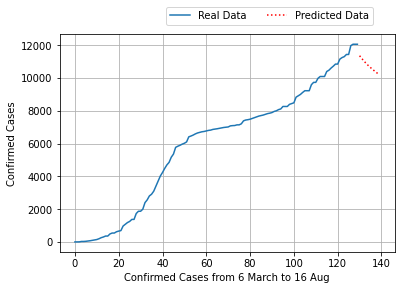

In [59]:
plt.figure()
plt.plot(sc.inverse_transform(data)[:,0],label="Real Data")
plt.plot(pd.DataFrame(predictions[:,0],index=range(data.shape[0],data.shape[0]+10)),label="Predicted Data",c="r",linestyle='dotted')
plt.ylabel("Confirmed Cases")
plt.xlabel("Confirmed Cases from 6 March to 16 Aug")
plt.legend(bbox_to_anchor =(0.95, 1.15), ncol = 2)
plt.grid()
plt.show()

# Ensemble Bothe algorithm

In [60]:
y=sc.inverse_transform(data)[:,0]

In [61]:
predictin_gru=pd.DataFrame(predictions[:,0],index=range(data.shape[0],data.shape[0]+10))

In [62]:
ensemble=(predictin_gru+ predictin_lstm)/2

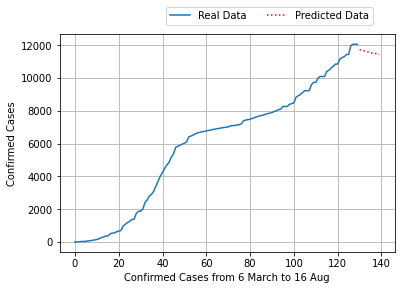

In [63]:
plt.figure()
plt.plot(y,label="Real Data")
plt.plot(ensemble,label="Predicted Data",c="r",linestyle='dotted')
plt.ylabel("Confirmed Cases")
plt.xlabel("Confirmed Cases from 6 March to 16 Aug")
plt.legend(bbox_to_anchor =(0.95, 1.15), ncol = 2)
plt.grid()
plt.show()

# > > > > > > > > >  > >             ---------- Ignore below code for testing purpose only

---------------

do evaluation of both model sepretly.
train a model with full data for forecating and for evalution do different code.
its
 improve the forecasting accuracy

 # Use MAE ( mean absolute error) for evaluation
 
 here we perform testing sepretly on both model



In [ ]:
data=df.drop(['total_tested'], axis=1)

In [ ]:
label=df['confirmed']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
Train = sc.fit_transform(data)

In [ ]:
X_Train = []

for i in range(10, Train.shape[0]):
    
    X_Train.append(Train[i-10:i])

X_Train = np.array(X_Train)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
Y_Train = scl.fit_transform(np.array(label.shift(-9)[0:120]).reshape(-1,1))

In [ ]:
print((X_Train.shape,Y_Train.shape))

((120, 10, 3), (120, 1))


# Training testing splitting

In [ ]:
X_test=X_Train[-10:,:,:]
y_test=Y_Train[-10:]
X_train=X_Train[0:-10,:,:]
Y_train=Y_Train[0:-10]
print(X_train.shape,Y_train.shape,X_test.shape,y_test.shape)

(110, 10, 3) (110, 1) (10, 10, 3) (10, 1)


In [ ]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 100, input_shape = (X_Train.shape[1], 3)))


regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mse', metrics=['mae'])

In [ ]:
regressor.fit(X_Train, Y_Train, epochs = 40,batch_size = 4)

Epoch 1/40
30/30 [==============================] - 0s 5ms/step - loss: 0.0677 - mae: 0.2019
Epoch 2/40
30/30 [==============================] - 0s 5ms/step - loss: 0.0081 - mae: 0.0683
Epoch 3/40
30/30 [==============================] - 0s 5ms/step - loss: 0.0015 - mae: 0.0284
Epoch 4/40
30/30 [==============================] - 0s 6ms/step - loss: 7.8815e-04 - mae: 0.0225
Epoch 5/40
30/30 [==============================] - 0s 5ms/step - loss: 9.5490e-04 - mae: 0.0257
Epoch 6/40
30/30 [==============================] - 0s 4ms/step - loss: 7.6343e-04 - mae: 0.0229
Epoch 7/40
30/30 [==============================] - 0s 4ms/step - loss: 7.0350e-04 - mae: 0.0220
Epoch 8/40
30/30 [==============================] - 0s 4ms/step - loss: 6.0934e-04 - mae: 0.0199
Epoch 9/40
30/30 [==============================] - 0s 4ms/step - loss: 5.6879e-04 - mae: 0.0196
Epoch 10/40
30/30 [==============================] - 0s 4ms/step - loss: 6.9270e-04 - mae: 0.0216
Epoch 11/40
30/30 [======================

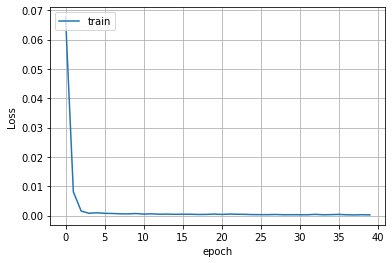

In [ ]:
plt.plot(regressor.history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
y_pred1=scl.inverse_transform(regressor.predict(X_test))

In [ ]:
y_pred1

array([[10446.432],
       [10708.552],
       [10834.46 ],
       [10914.589],
       [11085.282],
       [11214.578],
       [11329.756],
       [11509.166],
       [11663.105],
       [11816.283]], dtype=float32)

In [ ]:
y_test=scl.inverse_transform(y_test)

In [ ]:
y_test

array([[10843.],
       [10843.],
       [11146.],
       [11240.],
       [11296.],
       [11430.],
       [11430.],
       [11969.],
       [12053.],
       [12053.]])

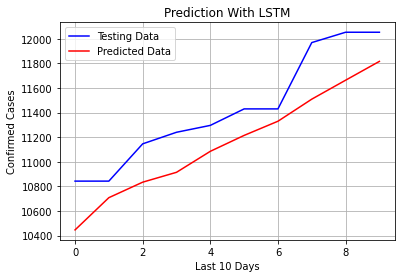

In [ ]:
plt.figure()
plt.plot(y_test,label="Testing Data",c="b")
plt.plot(y_pred1,label="Predicted Data",c="r")
plt.ylabel("Confirmed Cases")
plt.xlabel("Last 10 Days")
plt.legend()
plt.grid()
plt.title('Prediction With LSTM')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mean_absolute_error(y_test,y_pred1)

278.0796875000002

In [ ]:
regressor = Sequential()

# Adding the first GRu layer and some Dropout regularisation
regressor.add(GRU(units = 100, input_shape = (X_Train.shape[1], 3)))

regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
regressor.fit(X_Train, Y_Train, epochs = 40,batch_size = 4)

Epoch 1/40
30/30 [==============================] - 0s 4ms/step - loss: 0.0300
Epoch 2/40
30/30 [==============================] - 0s 4ms/step - loss: 0.0029
Epoch 3/40
30/30 [==============================] - 0s 4ms/step - loss: 8.3047e-04
Epoch 4/40
30/30 [==============================] - 0s 4ms/step - loss: 4.7996e-04
Epoch 5/40
30/30 [==============================] - 0s 4ms/step - loss: 2.5100e-04
Epoch 6/40
30/30 [==============================] - 0s 4ms/step - loss: 2.6772e-04
Epoch 7/40
30/30 [==============================] - 0s 4ms/step - loss: 1.8121e-04
Epoch 8/40
30/30 [==============================] - 0s 4ms/step - loss: 1.6376e-04
Epoch 9/40
30/30 [==============================] - 0s 4ms/step - loss: 1.5459e-04
Epoch 10/40
30/30 [==============================] - 0s 4ms/step - loss: 1.4026e-04
Epoch 11/40
30/30 [==============================] - 0s 4ms/step - loss: 1.6873e-04
Epoch 12/40
30/30 [==============================] - 0s 4ms/step - loss: 1.8421e-04
Epoch 13/

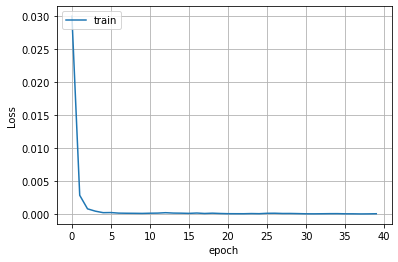

In [ ]:
plt.plot(regressor.history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
y_pred=scl.inverse_transform(regressor.predict(X_test))

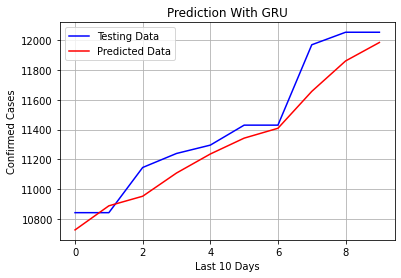

In [ ]:
#with GRU
plt.figure()
plt.plot(y_test,label="Testing Data",c="b")
plt.plot(y_pred,label="Predicted Data",c="r")
plt.ylabel("Confirmed Cases")
plt.xlabel("Last 10 Days")
plt.legend()
plt.title('Prediction With GRU')
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mean_absolute_error(y_test,y_pred)

122.70507812500018

# Ensemble the LSTM model with GRU model

In [ ]:
y_pred1
y_pred
y_pred_ensemble=(y_pred1+y_pred)/2

In [ ]:
y_pred_ensemble

array([[10586.885],
       [10798.756],
       [10893.846],
       [11011.711],
       [11160.878],
       [11278.699],
       [11369.373],
       [11582.771],
       [11761.763],
       [11900.352]], dtype=float32)

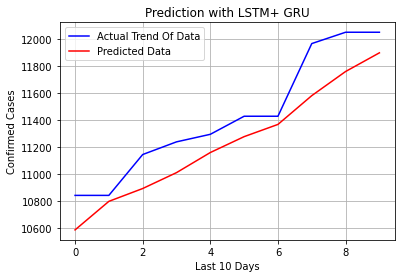

In [ ]:
plt.figure()
plt.plot(y_test,label="Actual Trend Of Data",c="b")
plt.plot(y_pred_ensemble,label="Predicted Data",c="r")
plt.ylabel("Confirmed Cases")
plt.xlabel("Last 10 Days")
plt.legend()
plt.grid()
plt.title('Prediction with LSTM+ GRU')
plt.show()

In [ ]:
mean_absolute_error(y_test,y_pred_ensemble)

195.7966796875002